# Goals

- The main goal of this project is to make a prediction of stock prices of PETR4.
- Additionally, I would like to work with 2-month predictions in order to figure out a way to find out nice opportunities for options on this stock. PETR4 options are amidst the most traded in the world.
- An extension to this project would be to build a bot to trade this stock.

## How

- First I'm going to make use of time series with the daily stock prices, probably LSTM or bidirectional LSTM, which are the most relevant. 
- Maybe I could try to put another variable like international price of oil or other oil stocks.

# Getting Data

In [4]:
#!pip install yfinance

In [5]:
import yfinance as yf

In [6]:
papel = yf.Ticker('PETR4.SA')
papel

yfinance.Ticker object <PETR4.SA>

In [7]:
dados= papel.history(start= '2007-01-01', end='2022-12-29')

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3966 entries, 2007-01-02 00:00:00-02:00 to 2022-12-28 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3966 non-null   float64
 1   High          3966 non-null   float64
 2   Low           3966 non-null   float64
 3   Close         3966 non-null   float64
 4   Volume        3966 non-null   int64  
 5   Dividends     3966 non-null   float64
 6   Stock Splits  3966 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 247.9 KB


# Exploratory Analysis

In [9]:
# Close price through the years

<AxesSubplot:xlabel='Date'>

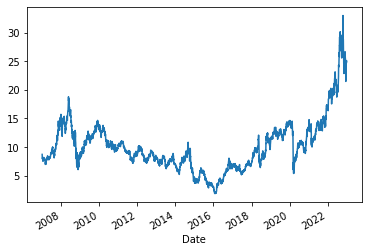

In [10]:
dados['Close'].plot()

In [11]:
# dividend distribution

In [12]:
div=dados[['Dividends']]
div=div[div['Dividends']>0]
div.head()

,Dividends
Date,
2007-01-02 00:00:00-02:00,0.2250
2007-04-03 00:00:00-03:00,0.1750
2007-08-20 00:00:00-03:00,0.2517
2007-10-08 00:00:00-03:00,0.2565
2008-01-14 00:00:00-02:00,0.1553


In [13]:
div.index

DatetimeIndex(['2007-01-02 00:00:00-02:00', '2007-04-03 00:00:00-03:00',
               '2007-08-20 00:00:00-03:00', '2007-10-08 00:00:00-03:00',
               '2008-01-14 00:00:00-02:00', '2008-04-07 00:00:00-03:00',
               '2008-12-29 00:00:00-02:00', '2009-04-09 00:00:00-03:00',
               '2009-07-06 00:00:00-03:00', '2009-10-01 00:00:00-03:00',
               '2009-12-21 00:00:00-02:00', '2010-04-23 00:00:00-03:00',
               '2010-05-24 00:00:00-03:00', '2010-08-02 00:00:00-03:00',
               '2010-11-03 00:00:00-02:00', '2010-12-22 00:00:00-02:00',
               '2011-03-22 00:00:00-03:00', '2011-04-29 00:00:00-03:00',
               '2011-05-12 00:00:00-03:00', '2011-08-03 00:00:00-03:00',
               '2011-11-14 00:00:00-02:00', '2012-01-03 00:00:00-02:00',
               '2012-03-20 00:00:00-03:00', '2012-05-14 00:00:00-03:00',
               '2013-04-30 00:00:00-03:00', '2014-04-03 00:00:00-03:00',
               '2018-05-22 00:00:00-03:00', '2018-0

In [14]:
#for date in div.index:
    #print(date)

In [15]:
div.index[0]

Timestamp('2007-01-02 00:00:00-0200', tz='America/Sao_Paulo')

In [16]:
dados.index.get_loc(div.index[2])

157

In [17]:
dados.index.get_loc('2007-08-20 00:00:00-03:00')

157

In [18]:
dados.iloc[157]

Open            8.221950e+00
High            8.241325e+00
Low             8.031725e+00
Close           8.149735e+00
Volume          2.473800e+07
Dividends       2.517000e-01
Stock Splits    0.000000e+00
Name: 2007-08-20 00:00:00-03:00, dtype: float64

In [19]:
locations_div=[]
for data in div.index:
    locations_div.append(dados.index.get_loc(data))

In [20]:
close_div=[]
for loc in locations_div:
    close_div.append(dados.iloc[loc]['Close'])

In [21]:
div['Price']=close_div

In [22]:
div['DY']=div['Dividends']/div['Price']

In [23]:
div

,Dividends,Price,DY
Date,,,
2007-01-02 00:00:00-02:00,0.225000,8.701067,0.025859
2007-04-03 00:00:00-03:00,0.175000,7.908743,0.022127
2007-08-20 00:00:00-03:00,0.251700,8.149735,0.030884
2007-10-08 00:00:00-03:00,0.256500,10.987377,0.023345
2008-01-14 00:00:00-02:00,0.155300,14.462683,0.010738
2008-04-07 00:00:00-03:00,0.102600,14.037210,0.007309
2008-12-29 00:00:00-02:00,0.042600,8.069036,0.005279
2009-04-09 00:00:00-03:00,0.351600,11.181712,0.031444
2009-07-06 00:00:00-03:00,0.300000,10.998056,0.027278


<AxesSubplot:xlabel='Date'>

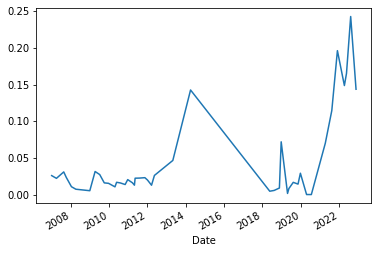

In [24]:
div['DY'].plot()

In [25]:
!git init
!git add .
!git commit -m 'petro analysis'
!git push origin master

Reinitialized existing Git repository in /home/lucas/code/LucasGama1207/Petro_prediction/.git/
error: 'Petro_prediction/' does not have a commit checked out
fatal: adding files failed
On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Petro.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Petro_prediction/

no changes added to commit (use "git add" and/or "git commit -a")
error: src refspec master does not match any
error: failed to push some refs to 'https://github.com/LucasGama1207/petr4_prediction.git'


In [26]:
!git init Petro_prediction

Reinitialized existing Git repository in /home/lucas/code/LucasGama1207/Petro_prediction/Petro_prediction/.git/


In [ ]:
!git add .
!git commit -m 'petro analysis'
!git push origin main

error: 'Petro_prediction/' does not have a commit checked out
fatal: adding files failed
On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Petro.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Petro_prediction/

no changes added to commit (use "git add" and/or "git commit -a")
Username for 'https://github.com': 